In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import glob
from PIL import Image

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
# path: path to folder of images
def get_formatted_images(path, cnt):
    image_list = []
    for idx, file_name in enumerate(glob.glob(path + '/*.png')):
        if idx >= cnt:
            break

        img = np.array(Image.open(file_name))

        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

        h, w, d = img.shape
        min_dim = min(h, w)
        img = img[0:min_dim, 0:min_dim]

        image_list.append(img)
    return image_list

def get_labels(images, label):
    labels = [label] * len(images)
    return labels

(25, 100, 100, 3)


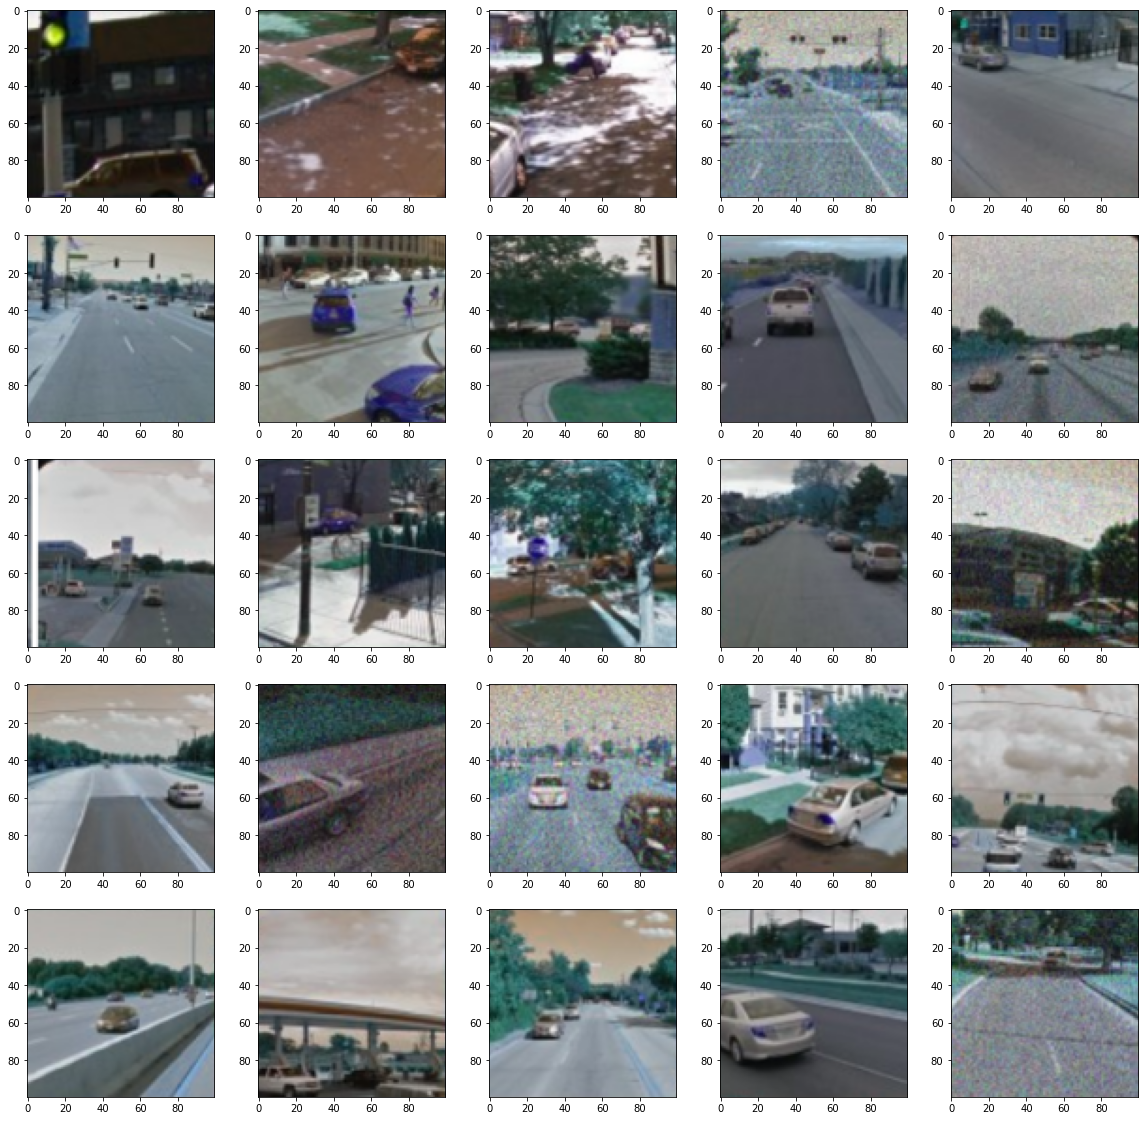

In [17]:
# from helper import get_formatted_images, get_labels

picture = 'Car'

#path = 'G:\\My Drive\\School\\6. Spring 2022\\EE379K - COMPUTER VISION\\CAPTCHA Solver\\archive\\Recaptcha Dataset\\Bicycle'
path = '/Users/andrewwhitaker/Downloads/Recaptcha Dataset/' + picture

num_imgs = 100
plt.figure(figsize=(20, 20))

# bicycle:
images = get_formatted_images(path, cnt=num_imgs)
labels = get_labels(images, picture)
test_images = []

for i, img in enumerate(images[:25]):
    dim = (100, 100)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    test_images.append(resized)
    plt.subplot(5, 5, i+1)
    plt.imshow(resized, cmap='gray')

test_images = np.array(test_images)
print(test_images.shape)

In [18]:
batch_size = 32
img_height = 100
img_width = 100

#data_dir = 'G:\\My Drive\\School\\6. Spring 2022\\EE379K - COMPUTER VISION\\CAPTCHA Solver\\archive\\Recaptcha Dataset'
data_dir = '/Users/andrewwhitaker/Downloads/Recaptcha Dataset/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 238399 files belonging to 17 classes.
Using 190720 files for training.
Found 238399 files belonging to 17 classes.
Using 47679 files for validation.


In [8]:
len(train_ds.class_names)

17

In [28]:
with tf.device("/cpu:0"):
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(100,100,3)),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomContrast(0.2)
  ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


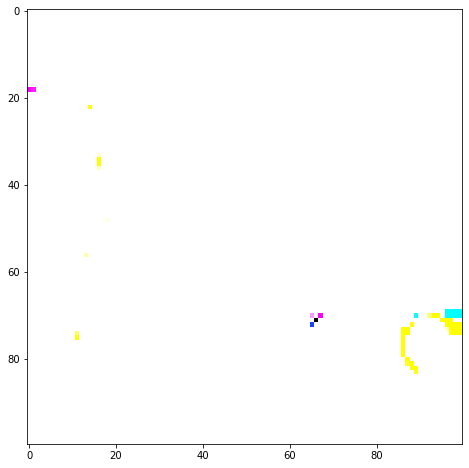

In [29]:
aug_images = []
aug_images.append(test_images[0])
aug_images = np.array(aug_images)
aug_image = data_augmentation(aug_images)
plt.imshow(aug_image[0])
#plt.imshow(test_images[0])

In [151]:
# use the google mobilev2 model without including the last dense layer
transfer_model = tf.keras.applications.MobileNetV2(input_shape=(100,100,3), include_top=False, weights='imagenet')
transfer_model.trainable = False

In [156]:
with tf.device("/cpu:0"):
    input = tf.keras.Input(shape=(100, 100, 3))
    x = data_augmentation(input)
    x = tf.keras.layers.Rescaling(1/127.5, offset=-1)(x)
    x = transfer_model(x, training=False)
    x = tf.keras.layers.AveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(len(train_ds.class_names))(x)
    model = tf.keras.Model(input, output)

In [158]:
with tf.device("/cpu:0"):
    model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [159]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds, epochs=1,validation_data=val_ds)

  19/5960 [..............................] - ETA: 8:11 - loss: 1.9400 - accuracy: 0.6513

KeyboardInterrupt: 

In [103]:
transfer_model.trainable = True
for layer in transfer_model.layers[:80]:
    layer.trainable = False
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [104]:
with tf.device("/cpu:0"):
    history_2 = model.fit(train_ds, epochs=10 ,validation_data=val_ds)

Epoch 1/9
5960/5960 [==============================] - 994s 166ms/step - loss: 0.2880 - accuracy: 0.9101 - val_loss: 0.1770 - val_accuracy: 0.9441
Epoch 2/9
5960/5960 [==============================] - 1032s 173ms/step - loss: 0.2013 - accuracy: 0.9354 - val_loss: 0.1401 - val_accuracy: 0.9559
Epoch 3/9
5960/5960 [==============================] - 1021s 171ms/step - loss: 0.1678 - accuracy: 0.9461 - val_loss: 0.1264 - val_accuracy: 0.9602
Epoch 4/9
5960/5960 [==============================] - 1070s 180ms/step - loss: 0.1464 - accuracy: 0.9525 - val_loss: 0.1171 - val_accuracy: 0.9629
Epoch 5/9
5960/5960 [==============================] - 1080s 181ms/step - loss: 0.1315 - accuracy: 0.9575 - val_loss: 0.1209 - val_accuracy: 0.9618
Epoch 6/9
5960/5960 [==============================] - 1078s 181ms/step - loss: 0.1195 - accuracy: 0.9609 - val_loss: 0.1034 - val_accuracy: 0.9676
Epoch 7/9
5960/5960 [==============================] - 1080s 181ms/step - loss: 0.1106 - accuracy: 0.9639 - val_l

In [30]:
plt.plot(history_2.history['accuracy'], color='red')
plt.plot(history_2.history['val_accuracy'], color='black')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history_2' is not defined

['Bicycle', 'Boat', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Mountain', 'Palm', 'Stairs', 'Taxi', 'Tow Truck', 'Traffic Light', 'Traffic Sign', 'Truck']
Crosswalk


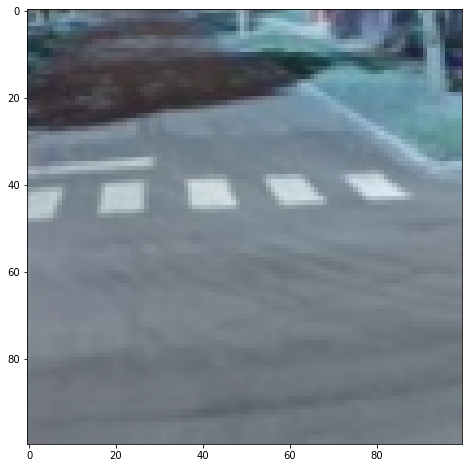

In [138]:
predictions = model.predict(test_images)
print(train_ds.class_names)

rand_idx = int(np.random.random() * len(test_images))

plt.imshow(test_images[rand_idx])
print(f"{train_ds.class_names[np.argmax(predictions[rand_idx])]}")

In [118]:
model.save('transfer_model.h5')